In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first
#!pip install --user seawater==3.3.4
import seawater

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [2]:
# Similar to 14 except removed all the processing code.

### Plan

Need to compare New Production, CO2 flux and SST at different locations and for different timescale resolutions. 
Assess which is the best Ensemble for Each of these.


What do we need

- Work in mols.


- CAFE New Production (Need to make detritus calculation)
- CO2 flux 

- New Production estimates
- Chlor A in mg CHL? 
- Landschutzer CO2 flux estimate (How about DELTA pCO2?)
- Reynolds OISST product


- And then detrend and deseasonalise to get different data product resolutions.

- Plot all ensembles over a Year?


In [3]:
#client

In [4]:
# Assumes data was loaded previously in 12 Validation run
use_dask=True
ensemble=25

In [29]:

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    #cluster = SLURMCluster(cores=8,processes=2,memory="47GB")
    client = Client(cluster)
    cluster.scale(cores=16)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43109 instead
  warnings.warn(


In [30]:
cluster

In [7]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/43063/status,
Dashboard: /proxy/43063/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.161:40597,Workers: 0
Dashboard: /proxy/43063/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [9]:
ls /g/data/xv83/dcfp/CAFE60v1

atmos_isobaric_daily.zarr.zip*  ocean_daily.zarr.zip*
atmos_isobaric_month.zarr.zip*  ocean_ens_mean_at_analysis.zarr.zip*
ice_month.zarr.zip*             ocean_force_month.zarr.zip*
land_month.zarr.zip*            ocean_month.zarr.zip*
ocean_bgc_daily.zarr.zip*       ocean_scalar_month.zarr.zip*
ocean_bgc_month.zarr.zip*


In [10]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40),lon_x=slice(120,290),lat_x=slice(-40,40),)

phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [11]:
# Load OBS

# Landschutzer
land_co2=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc')/365 #g/m2/day
land_co2=(land_co2.fgco2_smoothed.sel(lon=slice(120,290),lat=slice(-40,40))/12)*1000#/1000 #mmol/m2/day to match cafe. (ingassing is positive, outgassing neg)
#land_dpco2=(land_co2.pco2.sel(lon=slice(120,290),lat=slice(-40,40))


# Reynolds SST
rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc')
rey_sst=rey_sst.sst.sel(lon=slice(120,290),lat=slice(-40,40))
rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc').sel(lon=slice(120,290),lat=slice(-40,40))
#(obs_current.U_320.median(dim='time').sel(lat=0,method='nearest')).interpolate_na(dim='depth').plot.contourf(cmap='bwr')

In [12]:
# TOA Moorings
run_obs_current=False
if run_obs_current==True:
    obs_current=xr.open_mfdataset('../external_data/mooring_u_current/*.cdf')
    obs_current=obs_current.where(obs_current<=1e20)/100
    obs_current['time']=obs_current.time.astype('datetime64[M]')
    obs_current.to_netcdf('../processed_data/tao_adcp.nc')
obs_current=xr.open_dataset('../processed_data/tao_adcp.nc')

In [13]:
# Load the data we created


npp=xr.open_dataset('../processed_data/npp_rg/avg_npp_cafe.nc').avg_npp.chunk('auto')


cafe_u=xr.open_dataset('../processed_data/physics_ds/u_physics_feb7.nc').u
cafe_v=xr.open_dataset('../processed_data/physics_ds/v_physics_feb7.nc').v
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt
cafe_temp=xr.open_dataset('../processed_data/physics_ds/temp_physics_feb7.nc').temp
cafe_sst=xr.open_dataset('../processed_data/physics_ds/sst_physics_feb7.nc').sst
cafe_age=xr.open_dataset('../processed_data/physics_ds/age_global_physics_feb7.nc').age_global
#cafe_salt=xr.open_dataset('../processed_data/physics_ds/salt_physics_feb7.nc').salt
cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
dic=xr.open_dataset('../processed_data/dic_pac_feb7.nc') #physics_ds
upwelling_cafe=cafe_wt.sel(sw_ocean=-100,method='nearest')

cafe_u_tx=xr.open_dataset('../processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans
cafe_y_tx=xr.open_dataset('../processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans
cafe_u_tx_gm=xr.open_dataset('../processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm # Including eddies or subscale processes?
cafe_y_tx_gm=xr.open_dataset('../processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm


adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__


cafe_pprod=xr.open_dataset('../processed_data/physics_ds/pprod_gross_2d_bgc_feb7.nc').pprod_gross_2d
cafe_co2=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
cafe_co2_natural=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
cafe_co2_anth=cafe_co2-cafe_co2_natural

cafe_pCO2=xr.open_dataset('../processed_data/physics_ds/pco2_bgc_feb7.nc').pco2
cafe_paCO2=xr.open_dataset('../processed_data/physics_ds/paco2_bgc_feb7.nc').paco2
#cafe_co2flux=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
#cafe_natco2flux=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
#age=xr.open_dataset('../processed_data/physics_ds/pCO2_bgc_feb07.nc').age_global


dic_tx_v=xr.open_dataset('../processed_data/dic_v.nc').__xarray_dataarray_variable__
dic_tx_u=xr.open_dataset('../processed_data/dic_u.nc').__xarray_dataarray_variable__
#dic_tx_w=xr.open_dataset('../processed_data/dic_w.nc').__xarray_dataarray_variable__

anth_dic_tx_v=xr.open_dataset('../processed_data/dic_v_anth.nc').__xarray_dataarray_variable__
anth_dic_tx_u=xr.open_dataset('../processed_data/dic_u_anth.nc').__xarray_dataarray_variable__
#anth_dic_tx_w=xr.open_dataset('../processed_data/dic_w_anth.nc').__xarray_dataarray_variable__


# TREND FILES
cafe_co2_natural_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_co2_natural_trend_ensemble.nc')['1998-01 to 2015-01']
cafe_co2_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_co2_trend_ensemble.nc')['1998-01 to 2015-01']
cafe_sst_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_sst_trend_ensemble.nc')['1998-01 to 2015-01']
cafe_u_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_u_mean_depth_trend_ensemble.nc')['1998-01 to 2015-01']
cafe_v_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_v_mean_depth_trend_ensemble.nc')['1998-01 to 2015-01']
land_co2_trend=xr.open_dataset('../processed_data/var_ensembles/land_co2_trend_ensemble.nc')['1998-01 to 2015-01']
rey_sst_trend=xr.open_dataset('../processed_data/var_ensembles/rey_sst.sst_trend_ensemble.nc')['1998-01 to 2015-01']
tao_u_trend=xr.open_dataset('../processed_data/var_ensembles/obs_current.U_320_trend_ensemble.nc')['1998-01 to 2015-01']
tao_v_trend=xr.open_dataset('../processed_data/var_ensembles/obs_current.V_321_trend_ensemble.nc')['1998-01 to 2015-01']
dic_mean_depth_trend=xr.open_dataset('../processed_data/var_ensembles/dic_mean_depth_trend_ensemble.nc')['1998-01 to 2015-01']
adic_mean_depth_trend=xr.open_dataset('../processed_data/var_ensembles/adic_mean_depth_trend_ensemble.nc')['1998-01 to 2015-01']
upwelling_cafe_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_pprod_trend_ensemble.nc')['1998-01 to 2015-01']
cafe_pprod_trend=xr.open_dataset('../processed_data/var_ensembles/upwelling_cafe_trend_ensemble.nc')['1998-01 to 2015-01']
#npp_cafe_trend=xr.open_dataset('../processed_data/var_ensembles/npp_trend_ensemble.nc')['1998-01 to 2015-01']
#npp_cafe_trend=xr.open_mfdataset('../processed_data/var_ensembles/npp_slices/*nc',concat_dim='timeperiod')
# Npp Load Hack...
npp_cafe_trend=xr.open_mfdataset('../processed_data/var_ensembles/npp_slices/*nc')
holder=[]
for date in list(npp_cafe_trend):
    holder.append(npp_cafe_trend[date])#,dim='timeperiod')#.to_dataarray()
npp_cafe_trend=xr.concat(holder,dim='timeperiod')


co2_rodenbeck=(xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid.nc').sel(lon=slice(120,290),lat=slice(-40,40)).co2flux_ocean/12)*1000 #to mmolC

In [14]:
#Calculate ENSO

#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time<np.datetime64('2020-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values

cafe_u=xr.open_dataset('../processed_data/physics_ds/u_physics_feb7.nc').u
cafe_v=xr.open_dataset('../processed_data/physics_ds/v_physics_feb7.nc').v
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt
cafe_temp=xr.open_dataset('../processed_data/physics_ds/temp_physics_feb7.nc').temp
cafe_sst=xr.open_dataset('../processed_data/physics_ds/sst_physics_feb7.nc').sst
cafe_age=xr.open_dataset('../processed_data/physics_ds/age_global_physics_feb7.nc').age_global
cafe_salt=xr.open_dataset('../processed_data/physics_ds/salt_physics_feb7.nc').salt
cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
dic=xr.open_dataset('../processed_data/dic_pac_feb7.nc') #physics_ds
upwelling_cafe=cafe_wt.sel(sw_ocean=-100,method='nearest')

cafe_u_tx=xr.open_dataset('../processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans
cafe_y_tx=xr.open_dataset('../processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans
cafe_u_tx_gm=xr.open_dataset('../processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm # Including eddies or subscale processes?
cafe_y_tx_gm=xr.open_dataset('../processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm


In [15]:
pwd

'/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code'

In [16]:
# I cut out ensemble 25 previously, path is '/g/data4/xv83/np1383/processed_data/physics_ds/ .... tx_trans_physics_feb7.nc

dic=xr.open_dataset('../processed_data/dic_pac_feb7.nc') #physics_ds


cafe_x_tx=xr.open_dataset('../processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans
cafe_y_tx=xr.open_dataset('../processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans
cafe_x_tx_gm=xr.open_dataset('../processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm # Including eddies or subscale processes?
cafe_y_tx_gm=xr.open_dataset('../processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm
# y is v and x is u directions?


adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__

In [17]:
# Area grid  for Depth??
#!ls /g/data/xv83/rxm599
#/area.nc
# 

#docn=phys
#mdepth=docn.st_ocean.copy()
#dbot=np.copy(docn.sw_ocean)
#dthick=dbot*0
#dthick[1:50]=dbot[1:50]-dbot[0:49]

#dthick[0]=dbot[0]
#print(dthick,dbot)
#mdepth=mdepth*0+dthick
#mdepth 

## Add a few custom functions ive been making.
wrap functions to wrap functions that wrap functions
who wraps the wrapper for the wrapper? 

In [18]:

def plot_pacific(dat,levels=None,cmap='bwr'):

    fig = plt.figure(figsize=(12,7))

    # this declares a recentered projection for Pacific areas
    proj = ccrs.PlateCarree(central_longitude=180)
    proj._threshold /= 20.  # to make greatcircle smooth

    ax = plt.axes(projection=proj)
    # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree())

    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)

    lonm,latm=np.meshgrid(dat.lon,dat.lat)
    if levels is None:
        g=ax.contourf(dat.lon,dat.lat,dat, transform=ccrs.PlateCarree(),cmap=cmap)
    else:
        g=ax.contourf(dat.lon,dat.lat,dat, transform=ccrs.PlateCarree(),cmap=cmap,levels=levels)
    plt.colorbar(g,ax=ax,location='bottom',orientation='horizontal')
    # plot greatcircle arc

    ax.add_feature(cfeature.LAND, color='lightgray', zorder=100, edgecolor='k')
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.coastlines()

    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)

    plt.show()
    
    
#Seasonality?
#plot_pacific(sst_rey.groupby('time.month').mean().std(dim=['month']))

#stat=xarray_get_trend(rey_sst)
#plot_pacific(stat.sel(parameter=0)*365)

#stat=xarray_get_trend(sst_cafe.sel(ensemble=25))
#plot_pacific(stat.sel(parameter=0)*365)

In [19]:
def plot_pacific_subplot(dat,sb,title,levels=None,units=None,cmap='bwr',extend='neither',shrink=0.85,small_plot=False,remap=False):
   
    # this declares a recentered projection for Pacific areas
    if remap==False:
        proj = ccrs.PlateCarree(central_longitude=180)
        proj1=ccrs.PlateCarree()
        
    #elif remap==True:
    #    proj = ccrs.Miller(central_longitude=180)
    #    proj1=ccrs.Miller()


    if isinstance(sb,int):
        ax=plt.subplot(sb,projection=proj)
    else:
        ax=plt.subplot(sb[0],sb[1],sb[2],projection=proj)
    # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    if small_plot==True:
        ax.set_extent([150, 250, -10, 10], crs=proj1)
    elif small_plot==False:    
        ax.set_extent([120, 290, -40, 40], crs=proj1)

    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)

    lonm,latm=np.meshgrid(rey_sst.lon,rey_sst.lat)
    if isinstance(levels,type(None)):
         g=ax.contourf(dat.lon,dat.lat,dat, transform=proj1,cmap=cmap, extend=extend)
    else:
         g=ax.contourf(dat.lon,dat.lat,dat, transform=proj1,cmap=cmap,levels=levels, extend=extend)
   #,levels=levels)#vmin=vmin,vmax=vmax)
    #ax.clim(vmin,vmax)
    cb=plt.colorbar(g,ax=ax,location='bottom',orientation='horizontal',shrink=shrink)#,vmin=vmin,vmax=vmax)
    if units is not None:
        cb.set_label(units)#, rotation=270)
        
    # plot greatcircle arc
    #ax.set_clim(vmin,vmax)
    #plt.clim(vmin,vmax)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=100, edgecolor='k')
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.coastlines()
    ax.set_title(title)
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
    ax.set_aspect('auto')

# NEW FIGURES HERE

Mean Left Tr Right


- Rey SST:   
    - rey_sst
- CAFE SST
    - sst_cafe
- Mooring u:           
    - obs_current.U_320
- Cafe u
- Mooring V:           
    - obs_current.V_321
- Cafe v
- Upwelling at 50m 


In [20]:
# Unsure how to reduce the whitespace between figures? 

In [21]:
run_f1=True
run_f2=True

# Figure 1

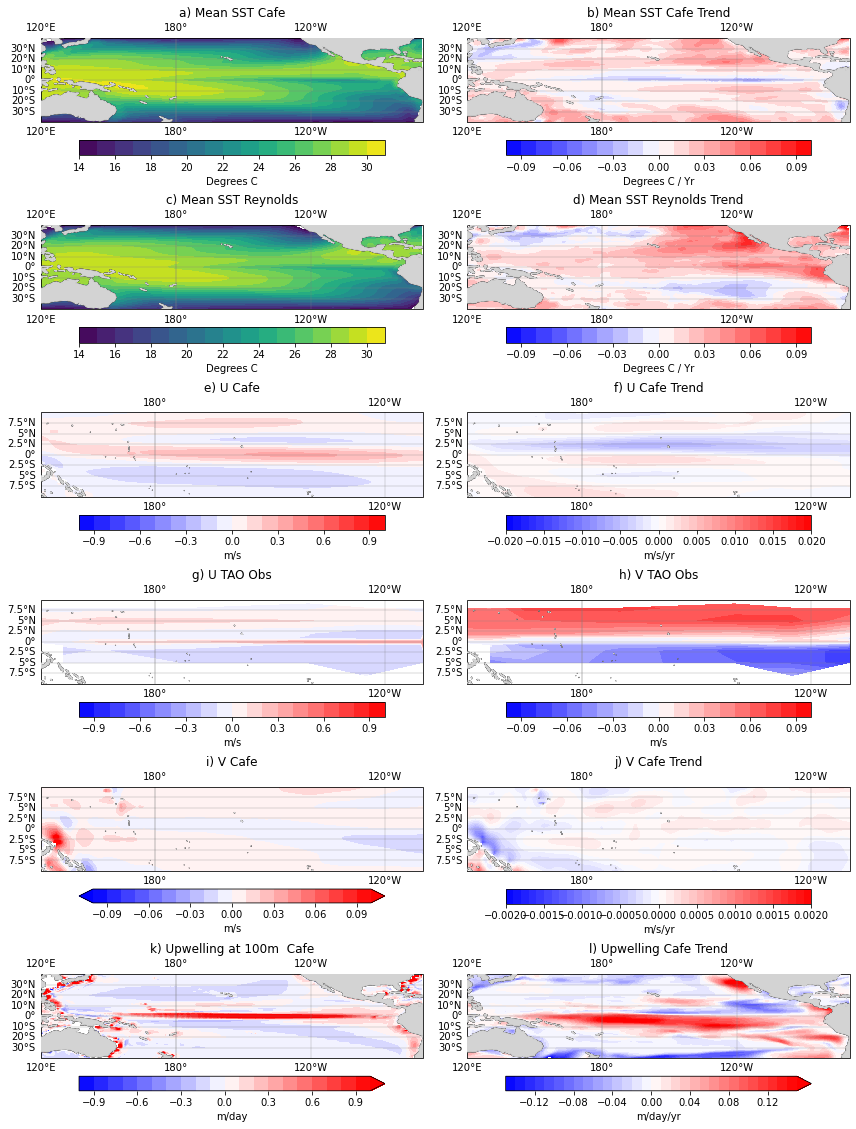

In [22]:
run_f1=True
if run_f1==True:
    sday='2000-01-01'
    eday='2020-01-01'

    # A3 is (11.69,16.53)
    #fig = plt.figure(figsize=((8.27)*1.5,11.69*1.5)) #Inches Portrait
    shrink=0.8
    fig = plt.figure(figsize=(12,18)) #Inches Portrait

    plot_pacific_subplot(cafe_sst.sel(time=slice(sday,eday)).mean(dim='time'),sb=721,title='a) Mean SST Cafe',levels=np.arange(14,32,1),units='Degrees C',cmap='viridis',shrink=shrink)
    plot_pacific_subplot(cafe_sst_trend.mean(dim='timeperiod').sel(parameter=0),sb=722,title='b) Mean SST Cafe Trend',levels=np.arange(-0.1,0.11,0.01),units='Degrees C / Yr',shrink=shrink)

    plot_pacific_subplot(rey_sst.sst.sel(time=slice(sday,eday)).mean(dim='time'),sb=723,title='c) Mean SST Reynolds',levels=np.arange(14,32,1),cmap='viridis',units='Degrees C',shrink=shrink)
    plot_pacific_subplot(rey_sst_trend.mean(dim='timeperiod').sel(parameter=0),sb=724,title='d) Mean SST Reynolds Trend',levels=np.arange(-0.1,0.11,0.01),units='Degrees C / Yr',shrink=shrink)

    plot_pacific_subplot(cafe_u.chunk({'st_ocean':-1}).mean('st_ocean').rename({'lon_x':'lon','lat_x':'lat'}).sel(time=slice(sday,eday)).mean(dim='time'),sb=725,title='e) U Cafe',units='m/s',levels=np.arange(-1,1.1,0.1),shrink=shrink,small_plot=True)
    plot_pacific_subplot(cafe_u_trend.mean(dim='timeperiod').sel(parameter=0).rename({'lon_x':'lon','lat_x':'lat'}),sb=726,title='f) U Cafe Trend',units='m/s/yr',levels=np.arange(-0.02,0.021,0.001),shrink=shrink,small_plot=True)

    plot_pacific_subplot(obs_current.U_320.interpolate_na(dim='lat').interpolate_na(dim='lon').mean(dim=['depth','time']),sb=727,levels=np.arange(-1,1.1,0.1),cmap='bwr',title='g) U TAO Obs',shrink=shrink,small_plot=True,units='m/s')
    plot_pacific_subplot(obs_current.V_321.interpolate_na(dim='lat').interpolate_na(dim='lon').mean(dim=['depth','time']),cmap='bwr',levels=np.arange(-0.1,0.11,0.01),title='h) V TAO Obs',sb=[7,2,8],shrink=shrink,small_plot=True,units='m/s')


    plot_pacific_subplot(cafe_v.chunk({'st_ocean':-1}).rename({'lon_x':'lon','lat_x':'lat'}).mean('st_ocean').sel(time=slice(sday,eday)).mean(dim='time'),sb=729,title='i) V Cafe',units='m/s',levels=np.arange(-0.1,0.11,0.01),extend='both',shrink=shrink,small_plot=True)
    plot_pacific_subplot(cafe_v_trend.mean(dim='timeperiod').sel(parameter=0).rename({'lon_x':'lon','lat_x':'lat'}),sb=[7,2,10],title='j) V Cafe Trend',units='m/s/yr',levels=np.arange(-0.002,0.0021,0.0001),shrink=shrink,small_plot=True)


    plot_pacific_subplot(upwelling_cafe.sel(time=slice(sday,eday)).mean(dim='time')*60*60*24,sb=[7,2,11],title='k) Upwelling at 100m  Cafe',units='m/day',levels=np.arange(-1,1.1,0.1),extend='max',shrink=shrink)
    plot_pacific_subplot(upwelling_cafe_trend.mean(dim='timeperiod').sel(parameter=0)*60*60*24,sb=[7,2,12],title='l) Upwelling Cafe Trend',units='m/day/yr',levels=np.arange(-0.15,0.16,0.01),extend='max',shrink=shrink)
    plt.tight_layout()
    #plt.subplots_adjust(wspace=0)


In [23]:
#(land_co2_trend.mean(dim='timeperiod').sel(parameter=0)*1000).plot()

In [22]:
run_f2=True
shrink=0.8

In [31]:
cluster

# Figure 3 ? 2 for now.

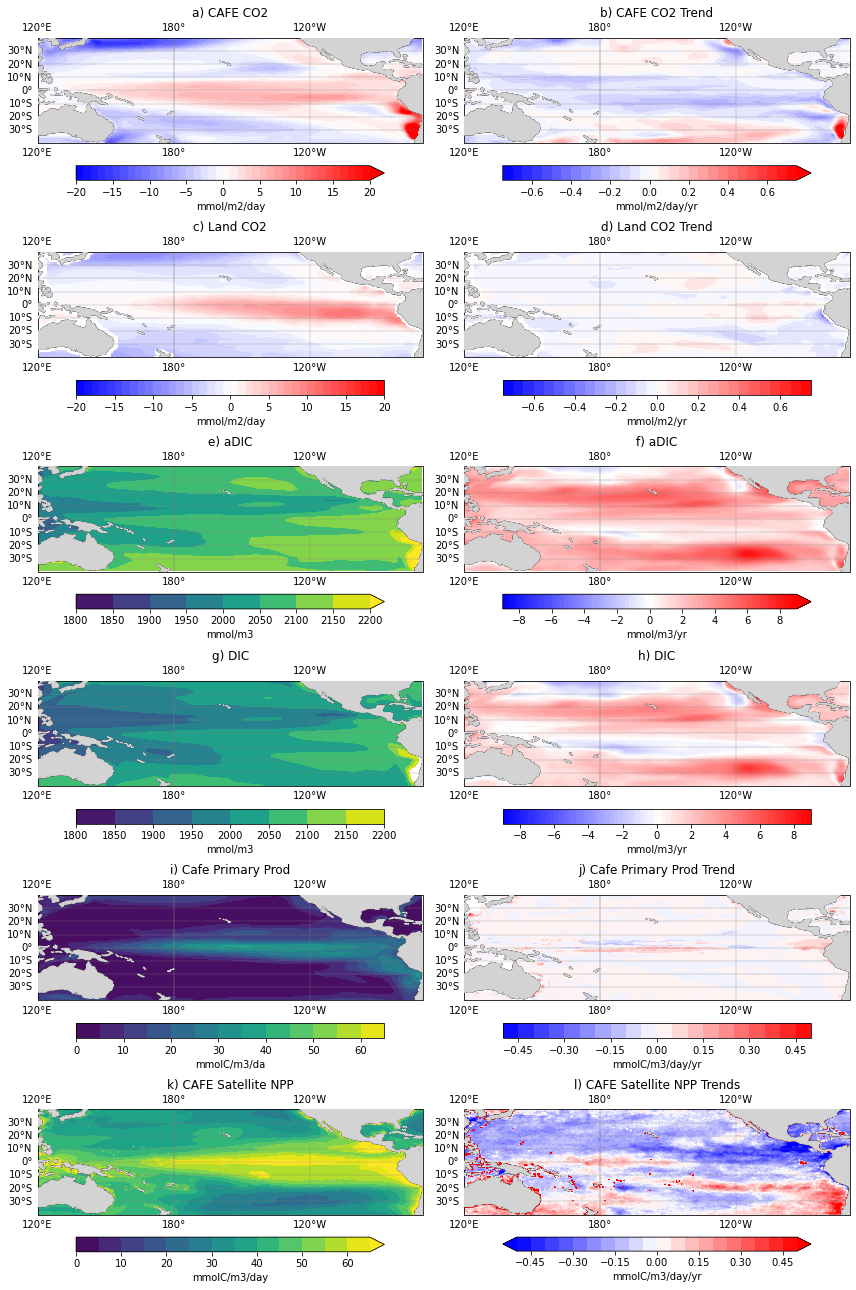

In [32]:
if run_f2==True:
    sday='2000-01-01'
    eday='2020-01-01'
    #fig = plt.figure(figsize=((8.27*2),11.69*2)) #Inches Portrait
    fig = plt.figure(figsize=(12,18)) 
    plot_pacific_subplot(cafe_co2.chunk('auto').sel(time=slice(sday,eday)).mean(dim='time')*60*60*-24,sb=621,title='a) CAFE CO2',levels=np.arange(-20,21,1),units='mmol/m2/day',shrink=shrink,extend='max')
    plot_pacific_subplot(cafe_co2_trend.chunk('auto').mean(dim='timeperiod').sel(parameter=0)*60*60*-24,sb=622,title='b) CAFE CO2 Trend',levels=np.arange(-0.75,0.8,0.05),units='mmol/m2/day/yr',shrink=shrink,extend='max')

    plot_pacific_subplot((land_co2.chunk('auto')).sel(time=slice(sday,eday)).mean(dim='time'),sb=623,title='c) Land CO2',levels=np.arange(-20,21,1),units='mmol/m2/day',shrink=shrink)
    plot_pacific_subplot(land_co2_trend.chunk('auto').mean(dim='timeperiod').sel(parameter=0)*1000,sb=624,title='d) Land CO2 Trend',levels=np.arange(-0.75,0.8,0.05),units='mmol/m2/yr',shrink=shrink)

    #plot_pacific_subplot(cafe_co2_natural.sel(time=slice(sday,eday)).mean(dim='time')*60*60*-24,sb=725,title='Natural CO2',levels=np.arange(-20,21,1),units='mmol/m3',extend='max',shrink=shrink)
    #plot_pacific_subplot(cafe_co2_natural_trend.mean(dim='timeperiod').sel(parameter=0)*60*60*-24,sb=726,title='Natural CO2',levels=np.arange(-0.75,0.8,0.05),units='mmol/m3/yr',extend='max',shrink=shrink)

    plot_pacific_subplot(adic_cafe.chunk('auto').sel(st_ocean=slice(0,-100)).mean(dim='st_ocean').sel(time=slice(sday,eday)).mean(dim='time'),sb=625,title='e) aDIC',levels=np.arange(1800,2250,50),units='mmol/m3',cmap='viridis',shrink=shrink,extend='max')
    plot_pacific_subplot(adic_mean_depth_trend.chunk('auto').mean(dim='timeperiod').sel(parameter=0),sb=626,title='f) aDIC',levels=np.arange(-9,9.25,0.25),units='mmol/m3/yr',shrink=shrink,extend='max')#,levels=np.arange(-0.025,0.025,0.0025))

    plot_pacific_subplot(dic_cafe.chunk('auto').sel(st_ocean=slice(0,-100)).mean(dim='st_ocean').sel(time=slice(sday,eday)).mean(dim='time'),sb=627,title='g) DIC',levels=np.arange(1800,2250,50),units='mmol/m3',cmap='viridis',shrink=shrink)
    plot_pacific_subplot(dic_mean_depth_trend.chunk('auto').mean(dim='timeperiod').sel(parameter=0),sb=[6,2,8],title='h) DIC',levels=np.arange(-9,9.25,0.25),units='mmol/m3/yr',shrink=shrink)


    plot_pacific_subplot(cafe_pprod.chunk('auto').sel(time=slice(sday,eday)).mean(dim='time')*60*60*24*6.625 ,sb=[6,2,9],title='i) Cafe Primary Prod',units='mmolC/m3/da',cmap='viridis',levels=np.arange(0,70,5),shrink=shrink)
    plot_pacific_subplot(cafe_pprod_trend.chunk('auto').mean(dim='timeperiod').sel(parameter=0)*60*60*24*6.625 ,sb=[6,2,10],title='j) Cafe Primary Prod Trend',units='mmolC/m3/day/yr',levels=np.arange(-0.5,0.55,0.05),shrink=shrink)

    plot_pacific_subplot(npp.chunk('auto').sel(time=slice(sday,eday)).mean(dim='time')/12,sb=[6,2,11],title='k) CAFE Satellite NPP',units='mmolC/m3/day',cmap='viridis',levels=np.arange(0,70,5),extend='max',shrink=shrink)#,remap=True)
    plot_pacific_subplot(npp_cafe_trend.chunk('auto').mean(dim='timeperiod').sel(parameter=0)/12,sb=[6,2,12],title='l) CAFE Satellite NPP Trends',units='mmolC/m3/day/yr',levels=np.arange(-0.5,0.55,0.05),extend='both',shrink=shrink)#,remap=True)
    #plot_pacific_subplot(xarray_get_trend(npp.sel(time=slice(sday,eday))).sel(parameter=0)*365,sb=[7,2,14],title='CAFE Satellite NPP Trends',units='mmol/m3/yr')

    plt.tight_layout()
    #plot_pacific_subplot(cafe_v.chunk({'st_ocean':-1}).rename({'lon_x':'lon','lat_x':'lat'}).mean('st_ocean').sel(time=slice(sday,eday)).mean(dim='time'),sb=527,title='V Cafe')
    #plot_pacific_subplot(xarray_get_trend(cafe_v.chunk({'st_ocean':-1}).rename({'lon_x':'lon','lat_x':'lat'}).mean('st_ocean').sel(time=slice(sday,eday))).sel(parameter=0),sb=528,title='V Cafe')


    #plot_pacific_subplot(upwelling.sel(time=slice(sday,eday)).mean(dim='time'),sb=529,title='Upwelling Cafe')
    #plot_pacific_subplot(xarray_get_trend(upwelling.sel(time=slice(sday,eday))).sel(parameter=0),sb=[5,2,10],title='Upwelling Cafe')

In [ ]:
#deseasonaliser(xarray_detrend(cafe_co2,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
#deseasonaliser(xarray_detrend(cafe_co2_natural,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='purple')
#deseasonaliser(xarray_detrend(land_co2,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')

In [ ]:
#npp.max().values#

## Interannual Variability

In [ ]:
# HAVING ISSUES HERE HMNMM>???


# Interannual Variability?
plt.figure(figsize=(20,12))
plt.subplot(311)
deseasonaliser(xarray_detrend(cafe_sst.sel(lat=slice(-10,10),time=slice('2000','2020')),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
#deseasonaliser(xarray_detrend(sst_cafe.sel(ensemble=25),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2,linestyle=':')
deseasonaliser(xarray_detrend(rey_sst.sel(lat=slice(-10,10),time=slice('2000','2020')),keep_intercept_values=False)).mean(dim=['lat','lon']).sst.plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE ens 25','Reynolds OISST'])
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('SST Interannual Variability')

plt.subplot(312)
deseasonaliser(xarray_detrend(cafe_co2.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*-24,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
deseasonaliser(xarray_detrend(cafe_co2_natural.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*-24,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='purple')
deseasonaliser(xarray_detrend(land_co2.sel(lat=slice(-10,10),time=slice('2000','2020')),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
deseasonaliser(xarray_detrend(co2_rodenbeck.sel(lat=slice(-10,10),time=slice('2000','2020'))*-1,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='g',linewidth=2,linestyle=':')
plt.legend(['Cafe CO2','Cafe CO2 natural','Landschutszer CO2','Rodenbeck CO2'])
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.ylim([-1.5,1.5])
plt.title('CO2 Interannual Variability')

plt.subplot(313)
#deseasonaliser(xarray_detrend(npp_cafe_25,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
#deseasonaliser(xarray_detrend(npp_cafe_25_sed,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linestyle=':',linewidth=2)
deseasonaliser(xarray_detrend(cafe_pprod.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*24*6.625,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='g',linewidth=2)
deseasonaliser(xarray_detrend(npp.sel(lat=slice(-10,10),time=slice('2000','2020')).chunk('auto')/12,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE Gross Primary Prod','Satellite NPP'])
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('NPP Interannual Variability')
plt.tight_layout()

In [ ]:
#(cafe_pprod.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*24*6.625).mean(dim=['lat','lon']).plot(c='g',linewidth=2)
#(npp.sel(lat=slice(-10,10),time=slice('2000','2020'))/12).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
#plt.legend(['Cafe GPP','Satellite NPP'])

In [ ]:
(cafe_sst.sel(lat=slice(-10,10),time=slice('2000','2020'))).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='k',linewidth=2)

In [ ]:
#((cafe_co2.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*-24)).mean(dim=['lat','lon']).groupby('time.month').mean().plot()

In [ ]:
# Seasonal Variability? 
plt.figure(figsize=(20,12))
plt.subplot(311)
((cafe_sst.sel(lat=slice(-10,10),time=slice('2000','2020')))).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='k',linewidth=2)
#deseasonaliser(xarray_detrend(sst_cafe.sel(ensemble=25),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2,linestyle=':')
((rey_sst.sel(lat=slice(-10,10),time=slice('2000','2020')))).mean(dim=['lat','lon']).sst.groupby('time.month').mean().plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE ens 25','Reynolds OISST'])
#plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('SST Seasonality')

plt.subplot(312)
((cafe_co2.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*-24)).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='k',linewidth=2)
((cafe_co2_natural.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*-24)).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='purple')
((land_co2.sel(lat=slice(-10,10),time=slice('2000','2020')))).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='b',linewidth=2,linestyle=':')
((co2_rodenbeck.sel(lat=slice(-10,10),time=slice('2000','2020')))).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='g',linewidth=2,linestyle=':')
plt.legend(['Cafe CO2','Cafe CO2 natural','Landschutszer CO2','Rodenbeck CO2'])
#plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
#plt.ylim([-1.5,1.5])
plt.title('CO2 Seasonality')

plt.subplot(313)
#deseasonaliser(xarray_detrend(npp_cafe_25,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
#deseasonaliser(xarray_detrend(npp_cafe_25_sed,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linestyle=':',linewidth=2)
((cafe_pprod.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*24*6.625)).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='g',linewidth=2)
((npp.sel(lat=slice(-10,10),time=slice('2000','2020'))/12)).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE Gross Primary Prod','Satellite NPP'])
#plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('NPP Seasonality')
plt.tight_layout()

# Figure 2: EUC Overview

How about including ENSO breakdown?

In [ ]:
contour_level=0.4
plt.figure(figsize=(18,4))


plt.subplot(141)
cafe_u.sel(lat_x=0,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1))
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe80.collections[0].set_label('CP')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC CP')



plt.subplot(142)
cafe_u.sel(lat_x=0,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1))
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe80.collections[0].set_label('EP')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC EP')


plt.subplot(143)
cafe_u.sel(lat_x=0,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1))
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe80.collections[0].set_label('Nina')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC Nina')

plt.subplot(144)
cafe_u.sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1))
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe80.collections[0].set_label('Neutral')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC Neutral')





/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contour(x, y, z, **kwargs)
/local/v45/np1383/tmp/ipykernel_3266128/1888658335.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])
/local/v45/np1383/tmp/ipykernel_3266128/1888658335.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,
/local/v45/np1383/tmp/ipykernel_3266128/1888658335.py:52: UserWarning: FixedFormatter should only be 

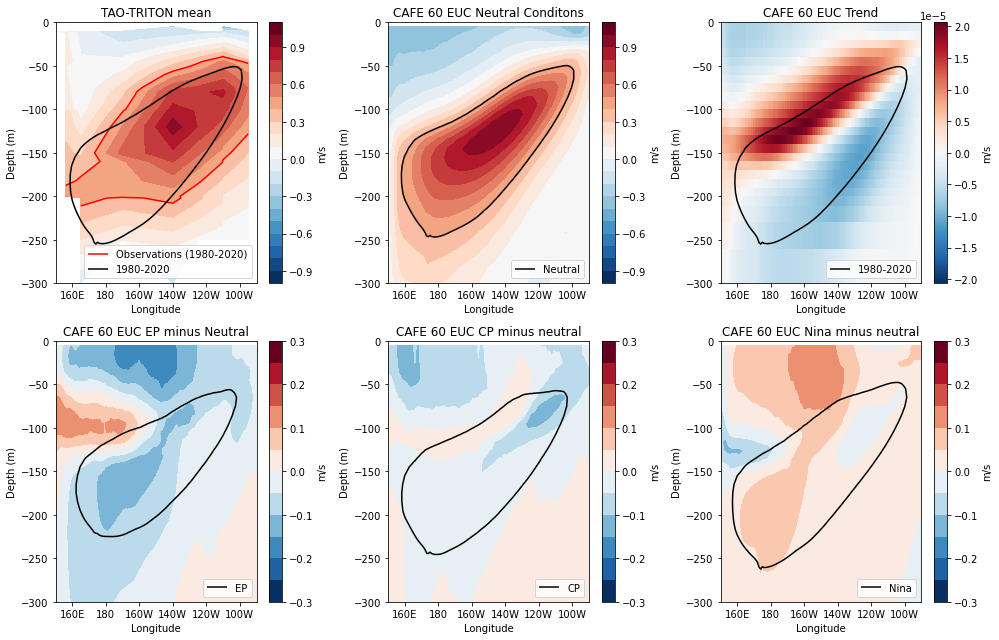

In [25]:
# New EUC Plot
plt.figure(figsize=(14,9))
contour_level=0.4
ax=plt.subplot(231)
euc_obs=obs_current.U_320.sel(lat=slice(-3,3)).mean(dim='lat').interpolate_na('depth').interpolate_na('lon')#.mean(dim=['time']).plot()
euc_obs['depth']=euc_obs['depth']*-1
euc_obs.sel(time=slice('1980','2020')).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1),cbar_kwargs={'label':'m/s'})

obs80=euc_obs.sel(time=slice('1980','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='r',label='Observations (1980-2020)')
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('1980','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
#cafe10=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='m')

obs80.collections[0].set_label('Observations (1980-2020)')
cafe80.collections[0].set_label('1980-2020')
#cafe10.collections[0].set_label('2010-2020')
plt.legend(loc='lower right')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')
plt.title('TAO-TRITON mean')
ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])

ax=plt.subplot(232)
cafe_u.sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1),cbar_kwargs={'label':'m/s'})
neutral_cafe=cafe_u.sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
neutral_cafe.collections[0].set_label('Neutral')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC Neutral Conditons')
ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])



ax=plt.subplot(233)
xarray_get_trend(cafe_u.sel(lat_x=0,method='nearest')).sel(parameter=0).plot(cbar_kwargs={'label':'m/s'})
#cafe_u.sel(lat_x=0,method='nearest').mean(dim='time').plot.contour(levels=[contour_level])
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('1980','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
#cafe10=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='m')

cafe80.collections[0].set_label('1980-2020')
#cafe10.collections[0].set_label('2010-2020')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC Trend')
ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])


ax=plt.subplot(234)
(cafe_u.sel(lat_x=0,method='nearest').sel(time=ep_events).mean(dim='time')-cafe_u.sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time')).plot.contourf(levels=np.arange(-0.3,0.35,0.05),cbar_kwargs={'label':'m/s'})
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
cafe80.collections[0].set_label('EP')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC EP minus Neutral')
ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])

ax=plt.subplot(235)
(cafe_u.sel(lat_x=0,method='nearest').sel(time=cp_events).mean(dim='time')-cafe_u.sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time')).plot.contourf(levels=np.arange(-0.3,0.35,0.05),cbar_kwargs={'label':'m/s'})
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
cafe80.collections[0].set_label('CP')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC CP minus neutral')
ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])

ax=plt.subplot(236)
(cafe_u.sel(lat_x=0,method='nearest').sel(time=nina_events).mean(dim='time')-cafe_u.sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time')).plot.contourf(levels=np.arange(-0.3,0.35,0.05),cbar_kwargs={'label':'m/s'})
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
cafe80.collections[0].set_label('Nina')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC Nina minus neutral')
ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])
plt.tight_layout()



In [ ]:
#euc_obs.sel(time=slice('2000','2025')).mean(dim='time').plot.contourf()

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(251)
levs=np.arange(-0.08,0.081,0.01)

cafe_v.sel(lat_x=-9,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.title('Meridonal Currents at 9S')
plt.xlim([150,270])

plt.subplot(252)
cafe_v.sel(lat_x=-7,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.title('Meridonal Currents at 7S')
plt.xlim([150,270])

plt.subplot(253)
cafe_v.sel(lat_x=-5,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 5S')

plt.subplot(254)
cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 3S')

plt.subplot(255)
cafe_v.sel(lat_x=-1,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 1S')

plt.subplot(256)
cafe_v.sel(lat_x=9,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 9N')

plt.subplot(257)
cafe_v.sel(lat_x=7,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 7N')

plt.subplot(258)
cafe_v.sel(lat_x=5,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 5N')

plt.subplot(259)
cafe_v.sel(lat_x=3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 3N')

plt.subplot(2,5,10)
cafe_v.sel(lat_x=1,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 1N')

plt.tight_layout()




#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

In [ ]:
dic_tx_v.sel(lat=-9,method='nearest')

In [ ]:
def get_area(dat,cs):
    #https://stackoverflow.com/a/70710241/9965678
    areaHold=[]
    for i in range(len(cs.collections)):
        cont = cs.collections[i]
        vs = cont.get_paths()
        contour_data=0
        for contour in vs:
            x=contour.vertices[:,0]
            y=contour.vertices[:,1]
            contour_data+=dat.sel(st_ocean=np.unique(y),lon=np.unique(x),method='nearest').sum().values#.drop_duplicates('lon')#.drop_duplicates('st_ocean')#.mean().values
            print(contour_data)#.mean())
            #area+=0.5*np.mean(y[:-1]*np.diff(x) - x[:-1]*np.diff(y))
            #print(len(vs))
            #print(area)
            #area=np.abs(area)
        areaHold.append(contour_data)#/len(vs))
    return areaHold

In [ ]:
def xarray_posneg_calc(ds,cutoff=0,mean=True,printer=True):
    pos=ds.where(ds>cutoff)
    neg=ds.where(ds<-cutoff)
    if mean==True:
        res=[pos.mean().values,neg.mean().values]
    elif mean==False:
        res=[pos.sum().values,neg.sum().values]
    if printer==True:
        print(np.array(res))
    return np.array(res)

In [ ]:
# NEW TX TEST


#adic_utx adic_vtx dic_vtx dic_utx

plt.figure(figsize=(20,7))
plt.subplot(251)
levs=None#np.arange(-150,175,25)
contour=[0]#60,-60]
lat=3
plt.subplot(241)
adic_vtx.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
adic_vtx.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(adic_vtx.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
#print(asum)
plt.title('Neutral Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(242)
adic_vtx.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
adic_vtx.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(adic_vtx.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
#print(asum)
plt.title('EP Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])


plt.subplot(243)
adic_vtx.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
adic_vtx.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(adic_vtx.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 3N')
plt.xlim([150,270])


plt.subplot(244)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(adic_vtx.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
plt.title('Nina Meridonal DIC at 3N')
plt.xlim([150,270])


lat=-3
plt.subplot(245)
adic_vtx.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
adic_vtx.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(adic_vtx.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
plt.title('Neutral Meridonal DIC at 3S')
plt.xlim([150,270])

plt.subplot(246)
adic_vtx.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
adic_vtx.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(adic_vtx.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
plt.title('EP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(247)
adic_vtx.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
adic_vtx.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(adic_vtx.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(248)
adic_vtx.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
cs=adic_vtx.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(adic_vtx.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
#asum1=get_area(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'),cs)
plt.title('Nina Meridonal DIC at 3S')
plt.xlim([150,270])



plt.tight_layout()

# Mmol DIC/m2/s


#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(251)
levs=np.arange(-150,175,25)
contour=[0]#60,-60]
lat=3
plt.subplot(241)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).    mean(dim='time'))
#print(asum)
plt.title('Neutral Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(242)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
#print(asum)
plt.title('EP Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])


plt.subplot(243)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 3N')
plt.xlim([150,270])


plt.subplot(244)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
plt.title('Nina Meridonal DIC at 3N')
plt.xlim([150,270])


lat=-3
plt.subplot(245)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
plt.title('Neutral Meridonal DIC at 3S')
plt.xlim([150,270])

plt.subplot(246)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
plt.title('EP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(247)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(248)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
cs=dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
#asum1=get_area(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'),cs)
plt.title('Nina Meridonal DIC at 3S')
plt.xlim([150,270])



plt.tight_layout()

# Mmol DIC/m2/s


#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

In [ ]:
#(asum1[0]
plt.figure(figsize=(20,7))
plt.subplot(251)
levs=np.arange(-150,175,25)
contour=[0]#60,-60]
lat=3
plt.subplot(241)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
#print(asum)
plt.title('Neutral Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(242)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
#print(asum)
plt.title('EP Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])


plt.subplot(243)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 3N')
plt.xlim([150,270])


plt.subplot(244)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
plt.title('Nina Meridonal DIC at 3N')
plt.xlim([150,270])


lat=-3
plt.subplot(245)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
plt.title('Neutral Meridonal DIC at 3S')
plt.xlim([150,270])

plt.subplot(246)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
plt.title('EP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(247)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(248)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
cs=dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
#asum1=get_area(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'),cs)
plt.title('Nina Meridonal DIC at 3S')
plt.xlim([150,270])



plt.tight_layout()

# Mmol DIC/m2/s


#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))/1000)*12

In [ ]:
#(cafe_potential_density).sel(lat=3,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf()
(cafe_potential_density).sel(lat=3,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3])

In [ ]:
d1=1023
d2=1024.5
d3=1026.3

In [ ]:
1023

## Start Estimating the ENSO transport through EUC

Get sum area integration for AnthDIC flow in molC/s through each of the sides of the box.
